In [1]:
# Importing the libraries
import numpy as np
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# load data
X = pd.read_csv('BibGDMFeaturesMatrix_Preprocessed_OHEColumnsNamed.csv')
y = pd.read_csv('BibGDMDependentVariableLGAEncoded.csv')

In [4]:
y.size

848

In [5]:
y.value_counts()

0
0    761
1     87
dtype: int64

In [6]:
y.value_counts(normalize=True)*100

0
0    89.740566
1    10.259434
dtype: float64

In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 848 entries, 0 to 847
Data columns (total 57 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ethnicity_Other             848 non-null    float64
 1   ethnicity_South Asian       848 non-null    float64
 2   ethnicity_White             848 non-null    float64
 3   ethnicity_missing           848 non-null    float64
 4   maternalDiabetes_No         848 non-null    float64
 5   maternalDiabetes_Yes        848 non-null    float64
 6   maternalDiabetes_missing    848 non-null    float64
 7   fhEclampsia_No              848 non-null    float64
 8   fhEclampsia_Not documented  848 non-null    float64
 9   fhEclampsia_Yes             848 non-null    float64
 10  fhEclampsia_missing         848 non-null    float64
 11  gdm_Yes                     848 non-null    float64
 12  gdmDiet_No                  848 non-null    float64
 13  gdmDiet_Yes                 848 non

In [8]:
# define a function that will evaluate the model performance 
def evaluate_model(y_test, y_pred):
    from sklearn import metrics
    from sklearn.metrics import classification_report, confusion_matrix
    confusion = metrics.confusion_matrix(y_test, y_pred)
    
    import matplotlib.pyplot as plt
    import scikitplot as skplt
    disp  = skplt.metrics.plot_confusion_matrix(y_test, y_pred)
    disp.set_title("Confusion Matrix")
    plt.show()
    
    print(classification_report(y_test, y_pred))
    
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0] 
    
    print('Classification Accuracy: %.3f' % metrics.accuracy_score(y_test, y_pred))
    print('Classification Error: %.3f' % (1 - metrics.accuracy_score(y_test, y_pred)))
    print('Sensitivity: %.3f' % metrics.recall_score(y_test, y_pred))
    print('Specificity: %.3f' % (TN / float(TN + FP)))
    print('False Positive Rate: %.3f' % (FP / float(TN + FP)))
    print('Precision: %.3f' % (TP / float(TP + FP)))
    print('F1 Score: %.3f' % metrics.f1_score(y_test, y_pred))
    print('AUC: %.3f' % metrics.roc_auc_score(y_test, y_pred))

# Baseline Model

Logistic Regression Evaluation Metrics:
Model score: 0.918


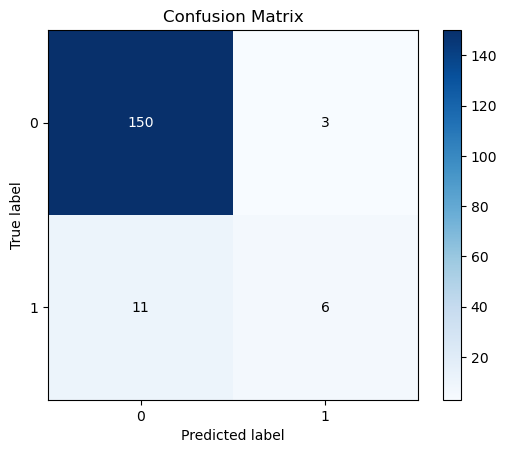

              precision    recall  f1-score   support

           0       0.93      0.98      0.96       153
           1       0.67      0.35      0.46        17

    accuracy                           0.92       170
   macro avg       0.80      0.67      0.71       170
weighted avg       0.91      0.92      0.91       170

Classification Accuracy: 0.918
Classification Error: 0.082
Sensitivity: 0.353
Specificity: 0.980
False Positive Rate: 0.020
Precision: 0.667
F1 Score: 0.462
AUC: 0.667


In [9]:
# split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# LOGISTIC REGRESSION MODEL
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='lbfgs')

# set max_iter=400 to overcome algortihm not converging

clf.fit(X_train, y_train)
print("Logistic Regression Evaluation Metrics:")

print("Model score: %.3f" % clf.score(X_test, y_test))

y_pred = clf.predict(X_test)

# store the predicted probabilities for class 1 (Baby is LGA)
y_pred_prob = clf.predict_proba(X_test)[:, 1]

evaluate_model(y_test, y_pred)

# 1. Univariate Selection
Statistical tests can be used to select those features that have the strongest relationship with the output variable.

The scikit-learn library provides the SelectKBest class that can be used with a suite of different statistical tests to select a specific number of features.

Many different statistical test scan be used with this selection method. For example the ANOVA F-value method is appropriate for numerical inputs and categorical data.

## ANOVA F-value

In [10]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_classif, k=10)
fs = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fs.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns

#print 10 best features
top10= featureScores.nlargest(10,'Score')
print(top10)

              Feature       Score
48       maxAbdomCirc  147.153168
53    maxFoetalWeight  129.631659
37  premacrosomia_Yes   63.607140
45     fastingGlucose   57.242748
52   meanFoetalWeight   57.006576
41      bookingWeight   50.129865
47      meanAbdomCirc   48.373766
55    varFoetalWeight   39.992035
42         bookingBMI   34.898018
56  rangeFoetalWeight   28.937984


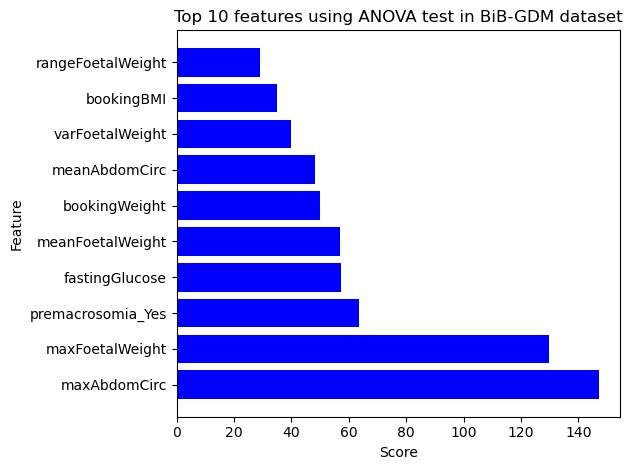

In [11]:
# Now plot top 10 features in histogram
import matplotlib.pyplot as plt

plt.figure()
#plt.xticks(rotation=90)
plt.ylabel("Feature")
plt.xlabel("Score")

plt.title("Top 10 features using ANOVA test in BiB-GDM dataset")
plt.barh(top10['Feature'], top10['Score'], color='b', align='center')
plt.tight_layout()

plt.savefig('figures/featureselection/bib-gdm_anova_top10.png')

plt.show()

In [12]:
# display 2 decimal points only
#pd.options.display.float_format = "{:,.10f}".format

In [15]:
# make dataframe with features and their p values
p_values = pd.DataFrame({'Feature': X.columns, 'p_value':
                         bestfeatures.pvalues_}).sort_values('p_value')

pd.set_option('display.max_rows', 100)
# print (p_values) # print all features and their p_values

# print features with p values less 0.05 only
p_values[p_values['p_value'] < .05] 

#print(p_values)
top_p_values = p_values[p_values['p_value'] < .05]

display(top_p_values)

,Feature,p_value
48,maxAbdomCirc,2.452737e-31
53,maxFoetalWeight,4.818010e-28
37,premacrosomia_Yes,4.917192e-15
45,fastingGlucose,1.005242e-13
52,meanFoetalWeight,1.124923e-13
41,bookingWeight,3.025269e-12
47,meanAbdomCirc,7.049343e-12
55,varFoetalWeight,4.125482e-10
42,bookingBMI,5.031244e-09
56,rangeFoetalWeight,9.678245e-08


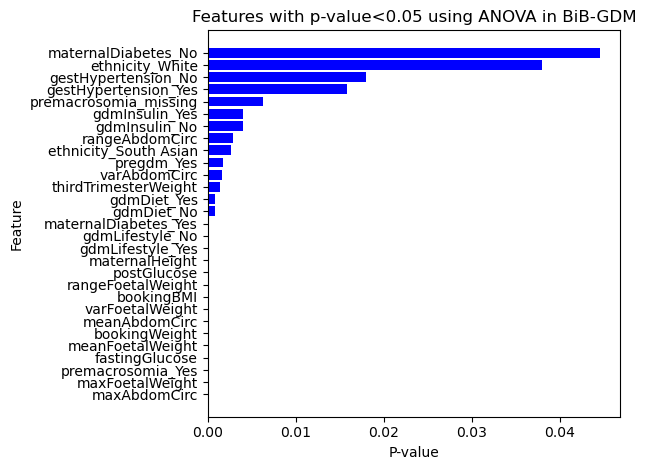

In [16]:
plt.figure()
#plt.xticks(rotation=90)
plt.ylabel("Feature")
plt.xlabel("P-value")
plt.title("Features with p-value<0.05 using ANOVA in BiB-GDM")
plt.barh(top_p_values['Feature'], top_p_values['p_value'], color='b', align='center')

plt.tight_layout()

plt.savefig('figures/featureselection/bib-gdm_anova_top_pvalues.png')

plt.show()

In [17]:
# Using training data only

# split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_classif, k=5)
fs = bestfeatures.fit(X_train,y_train)
dfscores = pd.DataFrame(fs.scores_)
dfcolumns = pd.DataFrame(X_train.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

              Feature       Score
48       maxAbdomCirc  112.744116
53    maxFoetalWeight   99.502268
37  premacrosomia_Yes   48.308234
41      bookingWeight   43.320420
52   meanFoetalWeight   43.271339
45     fastingGlucose   36.626642
47      meanAbdomCirc   35.660608
55    varFoetalWeight   33.528547
42         bookingBMI   27.608438
44     maternalHeight   23.895340


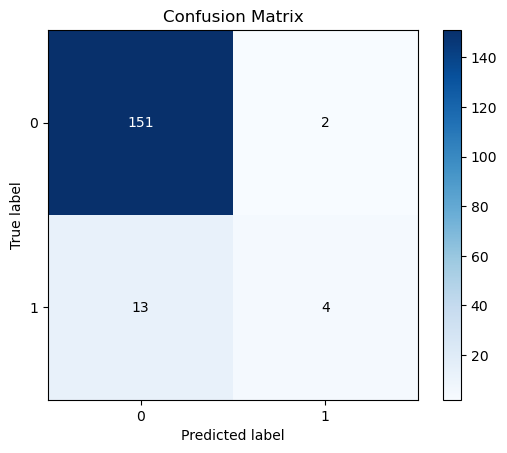

              precision    recall  f1-score   support

           0       0.92      0.99      0.95       153
           1       0.67      0.24      0.35        17

    accuracy                           0.91       170
   macro avg       0.79      0.61      0.65       170
weighted avg       0.90      0.91      0.89       170

Classification Accuracy: 0.912
Classification Error: 0.088
Sensitivity: 0.235
Specificity: 0.987
False Positive Rate: 0.013
Precision: 0.667
F1 Score: 0.348
AUC: 0.611


In [18]:
X_train_fs = fs.transform(X_train)
X_test_fs = fs.transform(X_test)

# fit the model
log = LogisticRegression(solver='lbfgs')
log.fit(X_train_fs, y_train)

y_pred = log.predict(X_test_fs)

# evaluate predictions
evaluate_model(y_test, y_pred)

In [19]:
# Tune k in SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

kbest = SelectKBest(f_classif) 
pipeline = Pipeline([('kbest', kbest), ('lr', LogisticRegression(solver='lbfgs'))]) 
grid_search = GridSearchCV(pipeline, {'kbest__k': [5, 10, 15, 20, 25,30,35,40,45,50,55], 'lr__C': np.logspace(-10, 10, 5)}, scoring ='recall') 
grid_search.fit(X_train_fs, y_train) 

GridSearchCV(estimator=Pipeline(steps=[('kbest', SelectKBest()),
                                       ('lr', LogisticRegression())]),
             param_grid={'kbest__k': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50,
                                      55],
                         'lr__C': array([1.e-10, 1.e-05, 1.e+00, 1.e+05, 1.e+10])},
             scoring='recall')

In [20]:
grid_search.best_params_

{'kbest__k': 5, 'lr__C': 100000.0}

In [21]:
grid_search.best_score_

0.24285714285714283

## Mutual Information

In [22]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=mutual_info_classif, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

                 Feature     Score
48          maxAbdomCirc  0.084448
53       maxFoetalWeight  0.075166
52      meanFoetalWeight  0.039633
51        rangeAbdomCirc  0.034950
56     rangeFoetalWeight  0.031267
50          varAbdomCirc  0.027653
43  thirdTrimesterWeight  0.027511
47         meanAbdomCirc  0.026432
41         bookingWeight  0.025799
37     premacrosomia_Yes  0.024200


In [23]:
# make dataframe with features and their p values
p_values = pd.DataFrame({'Feature': X.columns, 'p_value':
                         bestfeatures.pvalues_}).sort_values('p_value')

pd.set_option('display.max_rows', 100)
# print (p_values) # print all features and their p_values

# print features with p values less 0.05 only
p_values[p_values['p_value'] < .05] 

#keep features with p values less 0.05 only
p_values[p_values['p_value'] < .05] 
#print(p_values)

top_p_values = p_values[p_values['p_value'] < .05] 

print(top_p_values)

Empty DataFrame
Columns: [Feature, p_value]
Index: []


# 2. Feature Importance
Bagged decision trees like Random Forest and Extra Trees can be used to estimate the importance of features.

[7.25883434e-03 1.30936760e-02 1.41824478e-02 5.66116992e-03
 9.11803367e-03 1.32968579e-02 6.68345315e-03 4.63637997e-03
 3.87113311e-03 1.53117194e-03 0.00000000e+00 0.00000000e+00
 1.53779931e-02 1.40314553e-02 8.78250418e-03 8.57165680e-03
 1.03430759e-02 9.77901798e-03 2.00833095e-03 1.74460933e-03
 3.44741535e-03 3.07052862e-03 5.16849593e-03 4.68746839e-03
 9.84002185e-03 1.07285781e-02 0.00000000e+00 5.43461773e-03
 5.84422077e-03 6.40415666e-05 1.46038590e-02 5.63096241e-04
 1.44417655e-02 1.55116509e-02 1.71076466e-02 1.28971185e-02
 1.33146957e-02 4.90542617e-02 1.13393618e-02 2.43695610e-02
 1.99300251e-02 3.78902867e-02 3.11870132e-02 2.44551481e-02
 2.75581731e-02 5.02284239e-02 3.54613906e-02 3.51486197e-02
 6.29004057e-02 2.68527260e-02 3.57691588e-02 3.39133671e-02
 3.82731008e-02 5.82733082e-02 2.83008348e-02 4.06133099e-02
 4.17845020e-02]


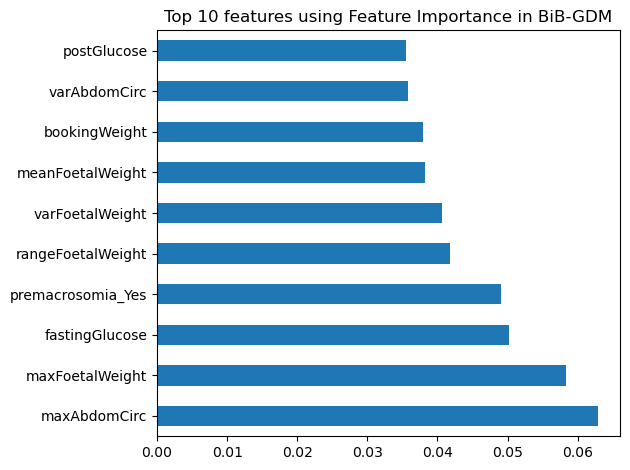

In [24]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier(n_estimators=100, random_state=42)

# different reseults when I run:
# model = ExtraTreesClassifier(n_estimators=10)
# different results every time I run this

model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')


#plot
plt.title("Top 10 features using Feature Importance in BiB-GDM")
plt.tight_layout()
plt.savefig('figures/featureselection/bib-gdm_featureImportance.png')

plt.show()

# 3. Recursive Feature Elimination


In [34]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression


# feature extraction
model = LogisticRegression()
rfe = RFE(model, n_features_to_select =10)
fit = rfe.fit(X, y)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)
print("Features Chosen: %s" % fit.get_support(1))


Num Features: 10
Selected Features: [False False False False False  True False  True False False False False
 False False False False False  True  True False False False  True  True
 False False False False  True False False False False False False False
 False  True  True False False False False False False False False False
  True False False False False False False False False]
Feature Ranking: [45 13 42 19  5  1 21  1 16 27 43 46 32 37 20 12 17  1  1 11 15  3  1  1
 34 30 48  4  1 47 35 29 14  2 25 28 38  1  1 36 22 33 23 40 26 10 41 18
  1  8  9 44  6 24  7 39 31]
Features Chosen: [ 5  7 17 18 22 23 28 37 38 48]


In [26]:
dfranking = pd.DataFrame(fit.ranking_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfranking],axis=1)
featureScores.columns = ['Feature','Ranking']  #naming the dataframe columns
# print(featureScores)
featureScores.loc[featureScores['Ranking'] == 1]

#print(featureScores.nlargest(10,'Score'))  #print 10 best features

,Feature,Ranking
5,maternalDiabetes_Yes,1
7,fhEclampsia_No,1
17,gdmLifestyle_Yes,1
18,gdmMetformin_No,1
22,gdmNotDoc_No,1
23,gdmNotDoc_Not documented,1
28,gestEclampsia_Yes,1
37,premacrosomia_Yes,1
38,premacrosomia_missing,1
48,maxAbdomCirc,1


In [30]:
# define f0.5 score
from sklearn.metrics import fbeta_score, make_scorer
f05_score = make_scorer(fbeta_score, beta=0.5)

Optimal number of features: 34


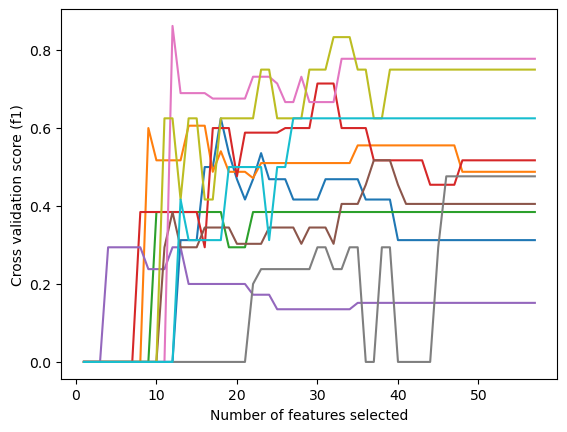

In [33]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification


# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")

min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(
    estimator=svc,
    step=1,
    cv=StratifiedKFold(10),
    scoring=f05_score,
    min_features_to_select=min_features_to_select,
)
rfecv.fit(X, y)

print("Optimal number of features: %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (f1)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

In [28]:
rfecv.cv_results_

{'mean_test_score': array([0.        , 0.        , 0.06382979, 0.06382979, 0.09803922,
        0.11320755, 0.14035088, 0.15517241, 0.22917364, 0.19166667,
        0.30771479, 0.33032787, 0.32786885, 0.31592109, 0.33518285,
        0.38789778, 0.38472486, 0.39672131, 0.38032787, 0.38621022,
        0.38621022, 0.36666667, 0.39354839, 0.39354839, 0.33793103,
        0.34094817, 0.33152735, 0.31198946, 0.3743505 , 0.3562963 ,
        0.34522145, 0.34522145, 0.3582996 , 0.35368421, 0.35368421,
        0.3582996 , 0.36363636, 0.35804702, 0.35804702, 0.36767241,
        0.36767241, 0.36767241, 0.36767241, 0.37643443, 0.38185654,
        0.37916667, 0.38185654, 0.37654321, 0.36146529, 0.37398374,
        0.37398374, 0.37398374, 0.37398374, 0.37398374, 0.37398374,
        0.37398374, 0.37398374]),
 'std_test_score': array([0.        , 0.        , 0.06382979, 0.06382979, 0.09803922,
        0.11320755, 0.14035088, 0.15517241, 0.06590833, 0.10833333,
        0.00263004, 0.03032787, 0.03278689, 0

In [29]:
X.columns

Index(['ethnicity_Other', 'ethnicity_South Asian', 'ethnicity_White',
       'ethnicity_missing', 'maternalDiabetes_No', 'maternalDiabetes_Yes',
       'maternalDiabetes_missing', 'fhEclampsia_No',
       'fhEclampsia_Not documented', 'fhEclampsia_Yes', 'fhEclampsia_missing',
       'gdm_Yes', 'gdmDiet_No', 'gdmDiet_Yes', 'gdmInsulin_No',
       'gdmInsulin_Yes', 'gdmLifestyle_No', 'gdmLifestyle_Yes',
       'gdmMetformin_No', 'gdmMetformin_Yes', 'gdmNoTreatment_No',
       'gdmNoTreatment_Yes', 'gdmNotDoc_No', 'gdmNotDoc_Not documented',
       'gestHypertension_No', 'gestHypertension_Yes',
       'gestHypertension_missing', 'gestEclampsia_No', 'gestEclampsia_Yes',
       'gestEclampsia_missing', 'fhDiabetes_No', 'fhDiabetes_Not documented',
       'fhDiabetes_Yes', 'pregdm_No', 'pregdm_Yes', 'pregdm_missing',
       'premacrosomia_No', 'premacrosomia_Yes', 'premacrosomia_missing',
       'maternalAge', 'parity', 'bookingWeight', 'bookingBMI',
       'thirdTrimesterWeight', 'maternalH

In [37]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

# feature extraction
model = LinearSVC()
rfe = RFE(model, n_features_to_select =10)
fit = rfe.fit(X, y)

dfranking = pd.DataFrame(fit.ranking_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfranking],axis=1)
featureScores.columns = ['Feature','Ranking']  #naming the dataframe columns
# print(featureScores)
featureScores.loc[featureScores['Ranking'] == 1]

#print(featureScores.nlargest(10,'Score'))  #print 10 best features


,Feature,Ranking
5,maternalDiabetes_Yes,1
7,fhEclampsia_No,1
20,gdmNoTreatment_No,1
22,gdmNotDoc_No,1
23,gdmNotDoc_Not documented,1
27,gestEclampsia_No,1
37,premacrosomia_Yes,1
48,maxAbdomCirc,1
52,meanFoetalWeight,1
54,minFoetalWeight,1
